<a href="https://colab.research.google.com/github/Narangaraw411/Dive-into-code/blob/main/Seq2Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

'''Sequence to sequence example in Keras (character-level).

This script demonstrates how to implement a basic character-level
sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.

# Summary of the algorithm:

- We start with input sequences from a domain (e.g. English sentences)
    and correspding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    Is uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.

# Data download:

English to French sentence pairs.
https://www.manythings.org/anki/fra-eng.zip

Lots of neat sentence pairs datasets can be found at:
https://www.manythings.org/anki/

# References:

- Sequence to Sequence Learning with Neural Networks
    https://arxiv.org/abs/1409.3215
- Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    https://arxiv.org/abs/1406.1078

# Problem 1 Machine translation execution and code reading

In [1]:
from __future__ import print_function
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

- line 1-4: Import library

In [2]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.

In [3]:
data_path = '/content/fra.txt'
lines = open(data_path, encoding='utf8').read().split('\n')
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
for line in lines[: min(num_samples, len(lines) - 1)]:
  input_text, target_text = line.split('\t')[:2]
  target_text = '\t' + target_text + '\n'
  input_texts.append(input_text.lower())
  target_texts.append(target_text.lower())
  for char in input_text:
    if char not in input_characters:
      input_characters.add(char)
  for char in target_text:
    if char not in target_characters:
      target_characters.add(char)
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 91
Max sequence length for inputs: 14
Max sequence length for outputs: 59


- Line 1-4: hyperparameter settings

- Line 1: get the data path
- Line 2: opening file
- Line 3 to 6: define variable input and target test and characters
- Line 8: loop along the length of the file string
- Line 9: Divide input text and target text
- Line 10 to 11: save to list
- Line 12 to 17: loop along the lenght of input text and add in input,target characters
- Line 18 to 19: sorted the characters
- Line 20-21: get lenght characters
- Line 22: get lenght max sequence
- Line 23: return values

In [4]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

- Line 1 to 3: assign an index to each charectar. But the characters do not match

In [5]:
encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens),dtype='float32')
decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens),dtype='float32')
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens),dtype='float32')
# print("endoder input data:\n{}".format(encoder_input_data[:][1]))
# print("decoder input data:\n{}".format(decoder_input_data[:][1]))
# print("decoder target data:\n{}".format(decoder_target_data[:][1]))
#Zeros

- line 1 to 3: definition encoder data and decoder data

In [6]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.

    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.

        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.


print(f"decoder target data shape: {decoder_target_data.shape}")
print(f"encoder input data shape: {encoder_input_data.shape}")

decoder target data shape: (10000, 59, 91)
encoder input data shape: (10000, 14, 70)


- Line 1 to 8: give value in encoder input data and decoder target data

In [7]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


- Line 1 to 4: Define an input sequence and process it.
- Line 5 to 6: discard `encoder_outputs` and only keep the states.
- Line 7 to 8: Set up the decoder, using `encoder_states` as initial state.
- Line 9 to 15: We set up our decoder to return full output sequences, and to return internal states as well. We don't use the return states in the training model, but we will use them in inference.

In [8]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,batch_size=batch_size,epochs=epochs,validation_split=0.2)
model.save('s2s.h5')

Epoch 1/100
125/125 [==============================] - 6s 22ms/step - loss: 1.0389 - val_loss: 1.1057
Epoch 2/100
125/125 [==============================] - 2s 13ms/step - loss: 0.9738 - val_loss: 1.0813
Epoch 3/100
125/125 [==============================] - 2s 13ms/step - loss: 0.9617 - val_loss: 1.0688
Epoch 4/100
125/125 [==============================] - 2s 15ms/step - loss: 0.9522 - val_loss: 1.0512
Epoch 5/100
125/125 [==============================] - 2s 15ms/step - loss: 0.9419 - val_loss: 1.0415
Epoch 6/100
125/125 [==============================] - 1s 10ms/step - loss: 0.9323 - val_loss: 1.0362
Epoch 7/100
125/125 [==============================] - 1s 10ms/step - loss: 0.9234 - val_loss: 1.0201
Epoch 8/100
125/125 [==============================] - 1s 10ms/step - loss: 0.9131 - val_loss: 1.0077
Epoch 9/100
125/125 [==============================] - 1s 10ms/step - loss: 0.9017 - val_loss: 0.9910
Epoch 10/100
125/125 [==============================] - 1s 10ms/step - loss: 0.889

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


- line 1: Define the model that will turn `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
- line 2 to 3: Run training
- line 4: Sava model

In [9]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.load_weights('./s2s.h5')

In [10]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 70)]           0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None, 91)]           0         []                            
                                                                                                  
 lstm (LSTM)                 [(None, 256),                334848    ['input_1[0][0]']             
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                            

In [11]:
#encoder_inputs = model.get_layer(name="input_3")
encoder = model.get_layer(name="lstm")

In [12]:
decoder_lstm_trained = model.get_layer(name="lstm_1")

In [13]:
decoder_dense = model.get_layer(name="dense")

In [14]:
# encoder model
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]
encoder_model = Model(encoder_inputs, encoder_states)

# decoder model
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm_trained(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model([decoder_inputs]+decoder_states_inputs, [decoder_outputs]+ decoder_states)

In [15]:
decoder_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, None, 91)]           0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 256)]                0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 256)]                0         []                            
                                                                                                  
 lstm_1 (LSTM)               [(None, None, 256),          356352    ['input_4[0][0]',             
                              (None, 256),                           'input_5[0][0]',       

In [16]:
# reserve tokenizer decoding
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

- line 1 to 8: inference mode (sampling).Here's the drill:
1) encode input and retrieve initial decoder state
2) run one step of decoder with this initial state and a "start of sequence" token as target.Output will be the next target token
3) Repeat with the current target token and current states
- Line 10 to 11:  Reverse-lookup token index to decode sequences back to something readable.

In [17]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char
        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.
        # Update states
        states_value = [h, c]
    return decoded_sentence

- Line 1: Define sampling models
- Line 2 to 3: Encode the input as state vectors.
- Line 4 to 5: Generate empty target sequence of length 1.
- Line 6 to 7: Populate the first character of target sequence with the start character.
- Line 8 to 14: Sampling loop for a batch of sequences (to simplify, here we assume a batch of size 1).
- Line 15 to 18: Sample a token
- Line 19 to 24: Exit condition: either hit max length or find stop character.
- Line 25 to 27: Update the target sequence (of length 1).
- Line 28 to 29: Update states
- Line 30: return value

In [19]:
input_sentence = "Hello"
test_sentence_tokenized = np.zeros((1, max_encoder_seq_length, num_encoder_tokens), dtype='float32')
for t, char in enumerate(input_sentence.lower()):
  test_sentence_tokenized[0, t, input_token_index[char]] = 1.
print(input_sentence)
print(decode_sequence(test_sentence_tokenized))

Hello
1/1 [==============================] - 0s 21ms/step
do le a se ue eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee


In [20]:
for seq_index in range(100):
    # Take one sequence (part of the training test)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 20ms/step
-
Input sentence: run.
Decoded sentence: coureeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
1/1 [==============================] - 0s 21ms/step
-
Input sentence: who?
Decoded sentence: sait eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
1/1 [==============================] - 0s 58ms/step
-
Input sentence: wow!
Decoded sentence: conreeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
1/1 [==============================] - 0s 20ms/step
-
Input sentence: wow!
Decoded sentence: conreeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
1/1 [==============================] - 0s 21ms/step
-
Input sentence: wow!
Decoded sentence: conreeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
1/1 [==============================] - 0s 31ms/step
-
Input sentence: duck!
Decoded sentence: attendee  eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
1/1 [===================

- Line 1: looping 100
- Line 2 to 5: Take one sequence (part of the training test) for trying out decoding.

# Problem 2 Running a trained model for image captioning

#### 1. Clone the repositories
```bash
git clone https://github.com/pdollar/coco.git
cd coco/PythonAPI/
make
python setup.py build
python setup.py install
cd ../../
git clone https://github.com/yunjey/pytorch-tutorial.git
cd pytorch-tutorial/tutorials/03-advanced/image_captioning/
```

#### 2. Download the dataset

```bash
pip install -r requirements.txt
chmod +x download.sh
./download.sh
```

#### 3. Preprocessing

```bash
python build_vocab.py   
python resize.py
```

#### 4. Train the model

```bash
python train.py    
```

#### 5. Test the model

#create data folder

In [ ]:
import os
os.makedirs("data", exist_ok=True)

# download data

In [ ]:
!wget http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip -P ./data/
!wget http://images.cocodataset.org/zips/train2014.zip -P ./data/
!wget http://images.cocodataset.org/zips/val2014.zip -P ./data/

--2024-05-15 06:00:03--  http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip
Resolving msvocds.blob.core.windows.net (msvocds.blob.core.windows.net)... 20.60.195.163
Connecting to msvocds.blob.core.windows.net (msvocds.blob.core.windows.net)|20.60.195.163|:80... connected.
HTTP request sent, awaiting response... 409 Public access is not permitted on this storage account.
2024-05-15 06:00:03 ERROR 409: Public access is not permitted on this storage account..

--2024-05-15 06:00:03--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.61.161, 52.216.62.113, 52.216.25.100, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.61.161|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘./data/train2014.zip’

train2014.zip       100%[===================>]  12.58G  32.8MB/s    in 6m 32s  

2024-05-15 06:06:35 (3

#unzip data
json data cannot be downloaded

In [ ]:
!unzip ./data/captions_train-val2014.zip -d ./data/
!rm ./data/captions_train-val2014.zip
!unzip ./data/train2014.zip -d ./data/
!rm ./data/train2014.zip
!unzip ./data/val2014.zip -d ./data/
!rm ./data/val2014.zip

Streaming output truncated to the last 5000 lines.
 extracting: ./data/val2014/COCO_val2014_000000535608.jpg  
 extracting: ./data/val2014/COCO_val2014_000000279145.jpg  
 extracting: ./data/val2014/COCO_val2014_000000243495.jpg  
 extracting: ./data/val2014/COCO_val2014_000000225791.jpg  
 extracting: ./data/val2014/COCO_val2014_000000428067.jpg  
 extracting: ./data/val2014/COCO_val2014_000000059383.jpg  
 extracting: ./data/val2014/COCO_val2014_000000558498.jpg  
 extracting: ./data/val2014/COCO_val2014_000000376123.jpg  
 extracting: ./data/val2014/COCO_val2014_000000191304.jpg  
 extracting: ./data/val2014/COCO_val2014_000000171062.jpg  
 extracting: ./data/val2014/COCO_val2014_000000014549.jpg  
 extracting: ./data/val2014/COCO_val2014_000000121152.jpg  
 extracting: ./data/val2014/COCO_val2014_000000276596.jpg  
 extracting: ./data/val2014/COCO_val2014_000000029431.jpg  
 extracting: ./data/val2014/COCO_val2014_000000036349.jpg  
 extracting: ./data/val2014/COCO_val2014_00000050

In [27]:
import nltk
import pickle
import argparse
from collections import Counter
from pycocotools.coco import COCO

nltk.download('punkt')


class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

def build_vocab(json, threshold):
    """Build a simple vocabulary wrapper."""
    coco = COCO(json)
    counter = Counter()
    ids = coco.anns.keys()
    for i, id in enumerate(ids):
        caption = str(coco.anns[id]['caption'])
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(tokens)

        if (i+1) % 1000 == 0:
            print("[{}/{}] Tokenized the captions.".format(i+1, len(ids)))

    # If the word frequency is less than 'threshold', then the word is discarded.
    words = [word for word, cnt in counter.items() if cnt >= threshold]

    # Create a vocab wrapper and add some special tokens.
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')

    # Add the words to the vocabulary.
    for i, word in enumerate(words):
        vocab.add_word(word)
    return vocab

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


json files can be downloaded from here:
https://www.kaggle.com/code/romanrybalko/ms-coco-dataset-processing/input

Download files and upload it

In [23]:
!unzip ./captions_train2014.json.zip -d ./data/
!rm ./captions_train2014.json.zip

Archive:  ./captions_train2014.json.zip
  inflating: ./data/captions_train2014.json  


# prepare vocab corpus

In [28]:
  vocab_path = 'data/vocab.pkl'
  caption_path = '/content/data/captions_train2014.json'
  threshold = 4
  vocab = build_vocab(json=caption_path, threshold=threshold)
  with open(vocab_path, 'wb') as f:
      pickle.dump(vocab, f)
  print("Total vocabulary size: {}".format(len(vocab)))
  print("Saved the vocabulary wrapper to '{}'".format(vocab_path))

loading annotations into memory...
Done (t=0.69s)
creating index...
index created!
[1000/414113] Tokenized the captions.
[2000/414113] Tokenized the captions.
[3000/414113] Tokenized the captions.
[4000/414113] Tokenized the captions.
[5000/414113] Tokenized the captions.
[6000/414113] Tokenized the captions.
[7000/414113] Tokenized the captions.
[8000/414113] Tokenized the captions.
[9000/414113] Tokenized the captions.
[10000/414113] Tokenized the captions.
[11000/414113] Tokenized the captions.
[12000/414113] Tokenized the captions.
[13000/414113] Tokenized the captions.
[14000/414113] Tokenized the captions.
[15000/414113] Tokenized the captions.
[16000/414113] Tokenized the captions.
[17000/414113] Tokenized the captions.
[18000/414113] Tokenized the captions.
[19000/414113] Tokenized the captions.
[20000/414113] Tokenized the captions.
[21000/414113] Tokenized the captions.
[22000/414113] Tokenized the captions.
[23000/414113] Tokenized the captions.
[24000/414113] Tokenized the 

# Image resize

In [31]:
import os
from PIL import Image


def resize_image(image, size):
    """Resize an image to the given size."""
    return image.resize(size, Image.ANTIALIAS)

def resize_images(image_dir, output_dir, size):
    """Resize the images in 'image_dir' and save into 'output_dir'."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    images = os.listdir(image_dir)
    num_images = len(images)
    for i, image in enumerate(images):
        with open(os.path.join(image_dir, image), 'r+b') as f:
            with Image.open(f) as img:
                img = resize_image(img, size)
                img.save(os.path.join(output_dir, image), img.format)
        if (i+1) % 100 == 0:
            print ("[{}/{}] Resized the images and saved into '{}'."
                   .format(i+1, num_images, output_dir))

In [32]:
image_dir = "/content/data/train2014"
output_dir = "./data/resized2014"
image_size = [256, 256]

resize_images(image_dir, output_dir, image_size)

<ipython-input-31-53a6ce01291e>:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  return image.resize(size, Image.ANTIALIAS)


[100/82783] Resized the images and saved into './data/resized2014'.
[200/82783] Resized the images and saved into './data/resized2014'.
[300/82783] Resized the images and saved into './data/resized2014'.
[400/82783] Resized the images and saved into './data/resized2014'.
[500/82783] Resized the images and saved into './data/resized2014'.
[600/82783] Resized the images and saved into './data/resized2014'.
[700/82783] Resized the images and saved into './data/resized2014'.
[800/82783] Resized the images and saved into './data/resized2014'.
[900/82783] Resized the images and saved into './data/resized2014'.
[1000/82783] Resized the images and saved into './data/resized2014'.
[1100/82783] Resized the images and saved into './data/resized2014'.
[1200/82783] Resized the images and saved into './data/resized2014'.
[1300/82783] Resized the images and saved into './data/resized2014'.
[1400/82783] Resized the images and saved into './data/resized2014'.
[1500/82783] Resized the images and saved i

# Model architecture

In [34]:

import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence


class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length

    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True)
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs

    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids


#Dataloader

In [35]:
import torch
import torchvision.transforms as transforms
import torch.utils.data as data
import os
import pickle
import numpy as np
import nltk
from PIL import Image
from pycocotools.coco import COCO


class CocoDataset(data.Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self, root, json, vocab, transform=None):
        """Set the path for images, captions and vocabulary wrapper.

        Args:
            root: image directory.
            json: coco annotation file path.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.root = root
        self.coco = COCO(json)
        self.ids = list(self.coco.anns.keys())
        self.vocab = vocab
        self.transform = transform

    def __getitem__(self, index):
        """Returns one data pair (image and caption)."""
        coco = self.coco
        vocab = self.vocab
        ann_id = self.ids[index]
        caption = coco.anns[ann_id]['caption']
        img_id = coco.anns[ann_id]['image_id']
        path = coco.loadImgs(img_id)[0]['file_name']

        image = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        # Convert caption (string) to word ids.
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target

    def __len__(self):
        return len(self.ids)


def collate_fn(data):
    """Creates mini-batch tensors from the list of tuples (image, caption).

    We should build custom collate_fn rather than using default collate_fn,
    because merging caption (including padding) is not supported in default.

    Args:
        data: list of tuple (image, caption).
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.

    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length (descending order).
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]
    return images, targets, lengths

def get_loader(root, json, vocab, transform, batch_size, shuffle, num_workers):
    """Returns torch.utils.data.DataLoader for custom coco dataset."""
    # COCO caption dataset
    coco = CocoDataset(root=root,
                       json=json,
                       vocab=vocab,
                       transform=transform)

    # Data loader for COCO dataset
    # This will return (images, captions, lengths) for each iteration.
    # images: a tensor of shape (batch_size, 3, 224, 224).
    # captions: a tensor of shape (batch_size, padded_length).
    # lengths: a list indicating valid length for each caption. length is (batch_size).
    data_loader = torch.utils.data.DataLoader(dataset=coco,
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers,
                                              collate_fn=collate_fn)
    return data_loader

# Model Training

In [36]:
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms

In [37]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [38]:
os.makedirs("models/", exist_ok=True)

In [39]:
 # Image preprocessing, normalization for the pretrained resnet
transform = transforms.Compose([
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                          (0.229, 0.224, 0.225))])

In [40]:
  # Load vocabulary wrapper
  with open("/content/data/vocab.pkl", 'rb') as f:
      vocab = pickle.load(f)

In [41]:
# Build data loader
image_dir = "/content/data/resized2014"
caption_path = "/content/data/captions_train2014.json"
batch_size = 16
num_workers = 4
embed_size = 256
hidden_size = 512
num_layers = 1
learning_rate = 0.001
num_epochs = 5
save_step = 1000
model_path = "models/"
log_step = 10

In [42]:
data_loader = get_loader(image_dir, caption_path, vocab,
                          transform, batch_size,
                          shuffle=True, num_workers=num_workers)

# Build the models
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)

# Train the models
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, captions, lengths) in enumerate(data_loader):

        # Set mini-batch dataset
        images = images.to(device)
        captions = captions.to(device)
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

        # Forward, backward and optimize
        features = encoder(images)
        outputs = decoder(features, captions, lengths)
        loss = criterion(outputs, targets)
        decoder.zero_grad()
        encoder.zero_grad()
        loss.backward()
        optimizer.step()

        # Print log info
        if i % log_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(epoch, num_epochs, i, total_step, loss.item(), np.exp(loss.item())))

        # Save the model checkpoints
        if (i+1) % save_step == 0:
            torch.save(decoder.state_dict(), os.path.join(
                model_path, 'decoder-{}-{}.ckpt'.format(epoch+1, i+1)))
            torch.save(encoder.state_dict(), os.path.join(
                model_path, 'encoder-{}-{}.ckpt'.format(epoch+1, i+1)))

loading annotations into memory...
Done (t=0.69s)
creating index...
index created!


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can al

Epoch [0/5], Step [0/25883], Loss: 9.2104, Perplexity: 10000.7547
Epoch [0/5], Step [10/25883], Loss: 6.1146, Perplexity: 452.4296
Epoch [0/5], Step [20/25883], Loss: 5.5146, Perplexity: 248.2986
Epoch [0/5], Step [30/25883], Loss: 5.1571, Perplexity: 173.6553
Epoch [0/5], Step [40/25883], Loss: 4.7227, Perplexity: 112.4666
Epoch [0/5], Step [50/25883], Loss: 4.8798, Perplexity: 131.6072
Epoch [0/5], Step [60/25883], Loss: 4.4897, Perplexity: 89.0967
Epoch [0/5], Step [70/25883], Loss: 4.6487, Perplexity: 104.4505
Epoch [0/5], Step [80/25883], Loss: 4.1841, Perplexity: 65.6352
Epoch [0/5], Step [90/25883], Loss: 4.3449, Perplexity: 77.0849
Epoch [0/5], Step [100/25883], Loss: 4.2577, Perplexity: 70.6488
Epoch [0/5], Step [110/25883], Loss: 4.2000, Perplexity: 66.6873
Epoch [0/5], Step [120/25883], Loss: 3.7180, Perplexity: 41.1818
Epoch [0/5], Step [130/25883], Loss: 4.2473, Perplexity: 69.9186
Epoch [0/5], Step [140/25883], Loss: 4.1251, Perplexity: 61.8760
Epoch [0/5], Step [150/2588

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


KeyboardInterrupt: 

# Prediction

In [43]:
import matplotlib.pyplot as plt

In [49]:
def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)

    if transform is not None:
        image = transform(image).unsqueeze(0)

    return image

In [50]:
# Image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                          (0.229, 0.224, 0.225))])

# Load vocabulary wrapper
with open("/content/data/vocab.pkl", 'rb') as f:
    vocab = pickle.load(f)


In [51]:
# Build data loader
image_dir = "/content/data/resized2014"
caption_path = "/content/data/captions_train2014.json"
batch_size = 16
num_workers = 4
embed_size = 256
hidden_size = 512
num_layers = 1
learning_rate = 0.001
num_epochs = 5
save_step = 1000
model_path = "models/"
log_step = 10

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<start> a man is riding a skateboard on a beach . <end>


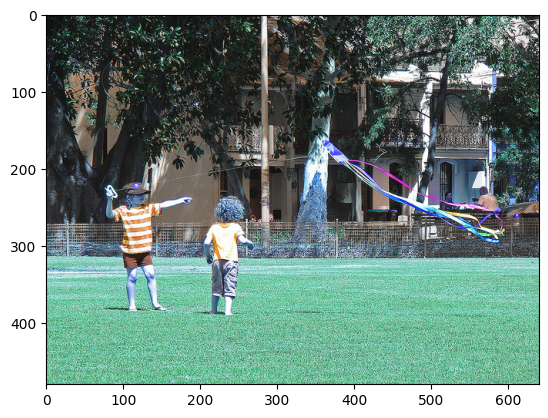

In [59]:
# Build models
encoder = EncoderCNN(embed_size).eval()  # eval mode (batchnorm uses moving mean/variance)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).eval()
encoder = encoder.to(device)
decoder = decoder.to(device)

# Load the trained model parameters
encoder_path = "/content/models/encoder-1-1000.ckpt"
decoder_path = "/content/models/decoder-1-1000.ckpt"
encoder.load_state_dict(torch.load(encoder_path))
decoder.load_state_dict(torch.load(decoder_path))

# Prepare an image
img_path='/content/data/val2014/COCO_val2014_000000553561.jpg'
image = load_image(img_path, transform)
image_tensor = image.to(device)

# Generate an caption from the image
feature = encoder(image_tensor)
sampled_ids = decoder.sample(feature)
sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)

# Convert word_ids to words
sampled_caption = []
for word_id in sampled_ids:
    word = vocab.idx2word[word_id]
    sampled_caption.append(word)
    if word == '<end>':
        break
sentence = ' '.join(sampled_caption)

# Print out the image and the generated caption
print (sentence)

import cv2
img = cv2.imread(img_path)
plt.imshow(img)
plt.show()

# Question 3 Investigate what to do if you want to run with Keras

If you want to run a PyTorch implementation using Keras and also utilize pre-trained weights from PyTorch, there are several steps you can follow. Please note that direct conversion of models or weights between PyTorch and Keras is not possible due to differences in their underlying frameworks. However, you can still achieve the desired outcome by adapting the model architecture and transferring the weights manually.

Here's a step-by-step guide on how you can proceed:

Understand the model architecture: Begin by studying the PyTorch model architecture that you want to convert to Keras. This includes understanding the layers, activation functions, and any specific modifications that might have been made to the original architecture.

Implement the Keras model: Start by creating a new model in Keras with the same architecture as the PyTorch model. You can use the Keras Sequential API or the functional API, depending on the complexity of the model. Make sure to define the same layers and activations as in the PyTorch model. Pay attention to any differences in layer ordering, padding, or parameter initialization between PyTorch and Keras.

Load the pre-trained PyTorch weights: Since direct conversion of weights is not possible, you need to load the pre-trained PyTorch weights separately and manually transfer them to the Keras model. First, save the PyTorch model's state dictionary using torch.save(model.state_dict(), 'model_weights.pth').

Adapt the weights for Keras: To adapt the PyTorch weights for use in Keras, you need to iterate through the layers of both models and manually transfer the weights. You can load the saved PyTorch weights using state_dict = torch.load('model_weights.pth'). Then, for each layer in the Keras model, extract the corresponding weights from the PyTorch state dictionary and set them in the Keras model using layer.set_weights(weights). Pay attention to the shape and ordering of the weights in PyTorch and Keras, as they might differ.

Freeze layers if necessary: If you want to keep some layers frozen (not trainable) in Keras, you can set the trainable attribute of those layers to False. This is particularly useful when using pre-trained weights, as you might want to freeze the initial layers and only fine-tune the later layers.

Compile and train the Keras model: Once the model architecture and weights have been adapted, compile the Keras model by specifying the optimizer, loss function, and any metrics you want to track during training. Then, you can train the model on your dataset using the Keras API, providing the input data and corresponding labels.

It's important to note that despite following these steps, the performance of the model may vary between PyTorch and Keras due to differences in optimization algorithms and numerical precision. It is advisable to evaluate and fine-tune the Keras model to ensure comparable performance to the original PyTorch implementation.

By following these steps, you should be able to convert a PyTorch implementation to Keras, including the usage of pre-trained weights from PyTorch.